 # Two high-level analyses:
 - Predict performance (accuracy) using a regression
 - Classify users into 'bad' vs 'good'--still need to define this but perhaps the threshold is any user < 70% and any user >= 70%

 For github issues and brainstorming features and analyses, use github:
 - https://github.com/ProjectSidewalk/sidewalk-quality-analysis/issues

In [1]:
import csv
import sys
import time
from datetime import datetime, timezone

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import parse as str_parse
import seaborn as sns
import sklearn.feature_selection
from dateutil import parser as parser
from imblearn.ensemble import (BalancedBaggingClassifier,
                               BalancedRandomForestClassifier,
                               EasyEnsembleClassifier)
from imblearn.over_sampling import ADASYN, SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn import linear_model, svm, tree
from sklearn.base import BaseEstimator
from sklearn.ensemble import (BaggingClassifier, BaggingRegressor,
                              ExtraTreesClassifier, ExtraTreesRegressor,
                              RandomForestClassifier, VotingClassifier)
from sklearn.feature_selection import RFECV, SelectFromModel, VarianceThreshold
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import (accuracy_score, confusion_matrix, precision_score,
                             r2_score, recall_score)
# from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import KFold, cross_val_score, train_test_split, StratifiedKFold
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.tree import DecisionTreeClassifier, export_graphviz
import multiprocess as mp
import warnings

from new_proximity.intersection_proximity import compute_proximity
from region_stats import RegionStats


OSError: libspatialindex_c.so.4: cannot open shared object file: No such file or directory

In [2]:
# users = pd.read_csv('ml-users.csv')
users = pd.read_csv('users_one_mission.csv')
users = users.set_index('user_id')
##%%
point_labels = pd.read_csv('sidewalk-seattle-label_point.csv')
point_labels.set_index('label_id', inplace=True)
##%%
# label_correctness = pd.read_csv('ml-label-correctness.csv')
label_correctness = pd.read_csv('ml-label-correctness-one-mission.csv')
##%%
label_correctness.set_index('label_id', inplace=True)
##%%
label_correctness = label_correctness.join(point_labels)
##%%
label_correctness = label_correctness[['user_id', 'label_type', 
    'correct', 'sv_image_x', 'sv_image_y', 'canvas_x', 'canvas_y', 
    'heading', 'pitch', 'zoom', 'lat', 'lng']]

##%%
users_for_analysis = users.index[users['labels_validated'] > 0]
label_correctness = label_correctness[label_correctness['user_id'].isin(users_for_analysis)]
users = users.loc[users_for_analysis]
##%%
label_correctness.update(label_correctness['correct'][~pd.isna(label_correctness['correct'])] == 't')
##%%
label_type_encoder = OrdinalEncoder()
##%%
label_correctness['label_type'] = label_type_encoder.fit_transform(label_correctness[['label_type']])


 # Intersection Proximity

In [3]:
def get_proximity_info(label):
    try:
        distance, middleness = compute_proximity(label.lat, label.lng, cache=True)
    except Exception:
        distance = -1
        middleness = -1
    
    return pd.Series({
        'proximity_distance': distance,
        'proximity_middleness': middleness
    })

label_correctness = label_correctness.join(label_correctness.apply(get_proximity_info, axis=1))


KeyboardInterrupt: 

 # CV Analysis
 cv_predictions = pd.read_csv('summary_user.csv').rename(

In [ ]:
label_types = ['CurbRamp', 'NoCurbRamp', 'Obstacle', 'SurfaceProblem']


In [ ]:
label_correctness = label_correctness.join(cv_predictions)

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(8, 8))
for i in range(len(label_types)):
    ax = axes[i//2][i%2]
    label_encoded = label_type_encoder.transform([[label_types[i]]])[0][0]
    selection = label_correctness[~pd.isna(label_correctness['correct']) & ~pd.isna(label_correctness['cv_confidence']) & (label_correctness['label_type'] == label_encoded)]
    ax.set_xlabel('CV Confidence')
    ax.set_ylabel('relative count')
    ax.set_title(label_types[i])
    ax.hist(selection[selection['correct'].astype(bool)]['cv_confidence'], alpha=0.5, label='correct', density=True)
    ax.hist(selection[~selection['correct'].astype(bool)]['cv_confidence'], alpha=0.5, label='incorrect', density=True)
    ax.legend()

fig.tight_layout()

In [ ]:
prob = np.zeros((4, 4))
for i in range(len(label_types)):
    for j in range(len(label_types)):
        i_encoded = label_type_encoder.transform([[label_types[i]]])[0][0]
        j_encoded = label_type_encoder.transform([[label_types[j]]])[0][0]

        selection = label_correctness[~pd.isna(label_correctness['correct']) 
            & (label_correctness['label_type'] == i_encoded)
            & (label_correctness['cv_label_type'] == j_encoded)]
        
        prob[i][j] = np.sum(selection['correct']) / len(selection)


prob

 # Population Density

In [ ]:
selection_all = label_correctness[['density', 'correct', 'label_type']]
selection_all = selection_all[~pd.isna(selection_all).any(axis=1)]

In [ ]:
/lab?fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(8, 8))
fig2, axes2 = plt.subplots(nrows=2, ncols=2, figsize=(8, 8))

for i in range(len(label_types)):
    ax = axes[i//2][i%2]
    label_encoded = label_type_encoder.transform([[label_types[i]]])[0][0]
    selection = selection_all[selection_all['label_type'] == label_encoded]
    ax.set_xlabel('Population density (people/sq. mile)')
    ax.set_ylabel('count')
    ax.set_title(label_types[i])
    nc, bins, _ = ax.hist(selection[selection['correct'] == True]['density'], density=False, bins=20, alpha=0.5, label='correct')
    ni, _, _ = ax.hist(selection[selection['correct'] == False]['density'], density=False, bins=bins, alpha=0.5, label='incorrect')
    ax.legend()

    ax2 = axes2[i//2][i%2]
    ax2.set_xlabel('Population density (people/sq. mile)')
    ax2.set_ylabel('probability correct')
    ax2.set_title(label_types[i])
    density_vals = (bins[:-1] + bins[1:])/2
    correct_prob = nc / (ni + nc)
    mask = ~np.isnan(correct_prob)
    density_vals = density_vals[mask]
    correct_prob = correct_prob[mask]
    ax2.scatter(density_vals, correct_prob)

    
    z = np.polyfit(density_vals, correct_prob, 1)
    p = np.poly1d(z)
    ax2.plot(density_vals, p(density_vals), 
    label=f"R={r2_score(correct_prob, p(density_vals)):.3f}")

    ax2.legend()


fig.tight_layout()
fig2.tight_layout()


 # Zone type

In [ ]:
rs = RegionStats('Zoning_Detailed.geojson')
label_correctness = label_correctness.join(
    label_correctness.apply(lambda x: pd.Series(rs.get_properties(x.lng, x.lat)), axis=1)
)


In [ ]:
selection_all = label_correctness[['CATEGORY_DESC', 'correct', 'label_type']]
selection_all = selection_all[~pd.isna(selection_all).any(axis=1)]
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(8, 10))
categories = selection_all['CATEGORY_DESC'].unique()

for i in range(len(label_types)):
    ax = axes[i//2][i%2]
    label_encoded = label_type_encoder.transform([[label_types[i]]])[0][0]
    selection = selection_all[selection_all['label_type'] == label_encoded]
    # ax.set_xlabel('Population density (people/sq. mile)')
    # ax.set_ylabel('count')
    ax.set_title(label_types[i])
    prob_correct = dict()
    for category in categories:
        if np.sum(selection['CATEGORY_DESC'] == category) > 100:
            prob_correct[category] = np.mean(selection['correct'][selection['CATEGORY_DESC'] == category])
        else:
            prob_correct[category] = 0
        # num_in[category] = np.sum(selection['CATEGORY_DESC'] == category)

    ax.bar(prob_correct.keys(), prob_correct.values())
    ax.set_ylim(0, 1)
    ax.tick_params(axis='x', labelrotation=90)

fig.tight_layout()

 # Classification

In [4]:
def prob_hist(probabilities, n_bins=5):
    hist = np.zeros(n_bins)
    hist[0] = np.sum(probabilities <= (1 / n_bins))
    for i in range(1, n_bins):
        hist[i] = np.sum(((i / n_bins) < probabilities) & (probabilities <= ((i+1) / n_bins)))

    # return hist / np.sum(hist)
    # return hist
    return [np.mean(probabilities), np.std(probabilities),
        np.percentile(probabilities, 25), np.percentile(probabilities, 50),
        np.percentile(probabilities, 75)]
def dearray(array):
    return np.array([list(l) for l in array])


 # Tyler's features

In [5]:
user_quality_features = pd.read_csv('all_users.csv')
user_quality_features.set_index('user_id', inplace=True)


In [6]:
def get_p_r(users, label_correctness):
    features = ['label_type', 'sv_image_y', 'canvas_x', 'canvas_y', 'heading', 'pitch', 'zoom', 'lat', 'lng',]
    proportion_labels = 0.1
    comparisons = pd.DataFrame()
    split_num = 0
    np.random.seed(0)

    for train_index, test_index in KFold(n_splits=5, shuffle=True, random_state=0).split(users.index):
        X_train, X_test = users.index[train_index], users.index[test_index]
        y_train, y_test = users['accuracy'][train_index], users['accuracy'][test_index]

        mask = np.random.permutation(np.arange(len(X_train)))
        users_labels_train = X_train[mask[:int(proportion_labels * len(mask))]]
        users_labels_test = X_train[mask[int(proportion_labels * len(mask)):]]

        train_labels = label_correctness[label_correctness['user_id'].isin(X_train)]
        test_labels = label_correctness[label_correctness['user_id'].isin(X_test)]
        #%%
        test_labels = test_labels.drop(columns='correct')
        #%%
        train_labels = train_labels[~pd.isna(train_labels['correct'])]
        train_labels = train_labels[~(pd.isna(train_labels[features]).any(axis=1))]
        # scaler = StandardScaler()
        # train_labels[features] = scaler.fit_transform(train_labels[features])

        #%%
        rfe_labels = RFECV(estimator=RandomForestClassifier(n_estimators=10), step=1, cv=StratifiedKFold(5),
               scoring='precision')
        clf_labels = RandomForestClassifier(random_state=0, n_jobs=-1, n_estimators=10)
        # clf_accuracy = BalancedBaggingClassifier(n_jobs=-1, random_state=0, n_estimators=100)
        rfe_accuracy = RFECV(estimator=RandomForestClassifier(n_estimators=10), step=1, cv=StratifiedKFold(5), scoring='f1')
        clf_accuracy = BalancedBaggingClassifier(random_state=0, n_jobs=-1, n_estimators=20)
        # clf = BalancedRandomForestClassifier(random_state=0)  

        # TODO don't eliminate all nans

        #%%
        # clf_labels.fit(train_labels[features], train_labels['correct'].astype(int))
    #     print('Training label classifier...')
        rfe_labels.fit(train_labels[train_labels['user_id'].isin(users_labels_train)][features].values, 
            train_labels[train_labels['user_id'].isin(users_labels_train)]['correct'].astype(int))

        clf_labels.fit(train_labels[train_labels['user_id'].isin(users_labels_train)][features].values[:, rfe_labels.support_], 
            train_labels[train_labels['user_id'].isin(users_labels_train)]['correct'].astype(int))

        train_labels = train_labels.join(pd.Series(
            data=clf_labels.predict_proba(train_labels[train_labels['user_id'].isin(users_labels_test)][features].values[:, rfe_labels.support_])[:, 1], 
            index=train_labels[train_labels['user_id'].isin(users_labels_test)].index).rename('prob'), how='outer')

        prob_hist_predictions = pd.DataFrame(train_labels[train_labels['user_id'].isin(users_labels_test)]
            .groupby('user_id').apply(lambda x:\
            prob_hist(x['prob'].values)).rename('prob'))

        prob_hist_predictions = prob_hist_predictions.join(user_quality_features)

    #     print('Training accuracy classifier...')
        rfe_accuracy.fit(np.concatenate((dearray(prob_hist_predictions['prob']), 
            prob_hist_predictions.drop(columns='prob').values), axis=1), 
            (y_train.loc[prob_hist_predictions.index] > 65).astype(int))

        clf_accuracy.fit(np.concatenate((dearray(prob_hist_predictions['prob']), 
            prob_hist_predictions.drop(columns='prob').values), axis=1)[:, rfe_accuracy.support_], 
            (y_train.loc[prob_hist_predictions.index] > 65).astype(int))
        #%%
        # Probabililty correct
        useful_test = test_labels[~pd.isna(test_labels[features]).any(axis=1)].copy()  # TODO don't eliminate all nans
        # useful_test[features] = scaler.transform(useful_test[features])
        # useful_test = useful_test.join(useful_test.apply(get_proximity_info, axis=1))
        useful_test.loc[:, 'prob'] = clf_labels.predict_proba(useful_test[features].values[:, rfe_labels.support_])[:, 1]

        # a = useful_test.groupby('user_id').apply(lambda x: prob_hist(x['prob']))
        # break
        #%%

        # Now predict accuracy

        def predict_accuracy(probs, features):
            # fig = plt.figure()
            # plt.xlim(0, 1)
            # plt.hist(probs)

            # selected_probs = probs[~np.isnan(probs)]
            # return np.mean(selected_probs)
            # return clf_accuracy.predict_proba([np.concatenate((prob_hist(probs), features))])[:, 1][0]
            return clf_accuracy.predict([np.concatenate((prob_hist(probs), features))[rfe_accuracy.support_]])[0]

    #     print('Making predictions...')
        mean_probs = useful_test.groupby('user_id').apply(lambda x: predict_accuracy(x['prob'].values, user_quality_features.loc[x.name])).rename('predicted')

        #%%
        comparison = pd.DataFrame((mean_probs, y_test, pd.Series(np.full((len(y_test)), split_num), name='split_num', index=y_test.index))).T
        comparison['prob_hist'] = useful_test.groupby('user_id').apply(lambda x: prob_hist(x['prob'].values))
        comparison['probs'] = useful_test.groupby('user_id').apply(lambda x: x['prob'].values)
        comparisons = comparisons.append(comparison)

        #%%

        split_num += 1

        # sys.stderr.write(f'{split_num} / 5\n')

    comparisons['accuracy'] = (comparisons['accuracy'] > 65).astype(int)

    mask = ~pd.isna(comparisons[['accuracy', 'predicted']]).any(axis=1)
    # print(precision_score(comparisons['accuracy'][mask], comparisons['predicted'][mask]))
    # print(recall_score(comparisons['accuracy'][mask], comparisons['predicted'][mask]))
    # print(accuracy_score(comparisons['accuracy'][mask], comparisons['predicted'][mask]))
    # print(confusion_matrix(comparisons['accuracy'][mask], comparisons['predicted'][mask]))

    return precision_score(comparisons['accuracy'][mask], comparisons['predicted'][mask]), recall_score(comparisons['accuracy'][mask], comparisons['predicted'][mask])


In [41]:
features = ['label_type', 'sv_image_y', 'canvas_x', 'canvas_y', 'heading', 'pitch', 'zoom', 'lat', 'lng',]

proportion_labels = 0.1
comparisons = pd.DataFrame()
split_num = 0
np.random.seed(0)

for train_index, test_index in KFold(n_splits=5, shuffle=True, random_state=0).split(users.index):
    X_train, X_test = users.index[train_index], users.index[test_index]
    y_train, y_test = users['accuracy'][train_index], users['accuracy'][test_index]

    mask = np.random.permutation(np.arange(len(X_train)))
    users_labels_train = X_train[mask[:int(proportion_labels * len(mask))]]
    users_labels_test = X_train[mask[int(proportion_labels * len(mask)):]]

    train_labels = label_correctness[label_correctness['user_id'].isin(X_train)]
    test_labels = label_correctness[label_correctness['user_id'].isin(X_test)]
    #%%
    test_labels = test_labels.drop(columns='correct')
    #%%
    train_labels = train_labels[~pd.isna(train_labels['correct'])]
    train_labels = train_labels[~(pd.isna(train_labels[features]).any(axis=1))]
    # scaler = StandardScaler()
    # train_labels[features] = scaler.fit_transform(train_labels[features])

    #%%
    rfe_labels = RFECV(estimator=RandomForestClassifier(n_estimators=10), step=1, cv=StratifiedKFold(5),
           scoring='precision')
    clf_labels = RandomForestClassifier(random_state=0, n_jobs=-1, n_estimators=10)
    # clf_accuracy = BalancedBaggingClassifier(n_jobs=-1, random_state=0, n_estimators=100)
    rfe_accuracy = RFECV(estimator=RandomForestClassifier(n_estimators=10), step=1, cv=StratifiedKFold(5), scoring='f1')
    clf_accuracy = BalancedBaggingClassifier(random_state=0, n_jobs=-1, n_estimators=20)
    # clf = BalancedRandomForestClassifier(random_state=0)  
    
    # TODO don't eliminate all nans

    #%%
    # clf_labels.fit(train_labels[features], train_labels['correct'].astype(int))
    print('Training label classifier...')
    rfe_labels.fit(train_labels[train_labels['user_id'].isin(users_labels_train)][features].values, 
        train_labels[train_labels['user_id'].isin(users_labels_train)]['correct'].astype(int))
    
    clf_labels.fit(train_labels[train_labels['user_id'].isin(users_labels_train)][features].values[:, rfe_labels.support_], 
        train_labels[train_labels['user_id'].isin(users_labels_train)]['correct'].astype(int))
    
    train_labels = train_labels.join(pd.Series(
        data=clf_labels.predict_proba(train_labels[train_labels['user_id'].isin(users_labels_test)][features].values[:, rfe_labels.support_])[:, 1], 
        index=train_labels[train_labels['user_id'].isin(users_labels_test)].index).rename('prob'), how='outer')
    
    prob_hist_predictions = pd.DataFrame(train_labels[train_labels['user_id'].isin(users_labels_test)]
        .groupby('user_id').apply(lambda x:\
        prob_hist(x['prob'].values)).rename('prob'))
    
    prob_hist_predictions = prob_hist_predictions.join(user_quality_features)
    
    print('Training accuracy classifier...')
    rfe_accuracy.fit(np.concatenate((dearray(prob_hist_predictions['prob']), 
        prob_hist_predictions.drop(columns='prob').values), axis=1), 
        (y_train.loc[prob_hist_predictions.index] > 65).astype(int))
    
    clf_accuracy.fit(np.concatenate((dearray(prob_hist_predictions['prob']), 
        prob_hist_predictions.drop(columns='prob').values), axis=1)[:, rfe_accuracy.support_], 
        (y_train.loc[prob_hist_predictions.index] > 65).astype(int))
    #%%
    # Probabililty correct
    useful_test = test_labels[~pd.isna(test_labels[features]).any(axis=1)].copy()  # TODO don't eliminate all nans
    # useful_test[features] = scaler.transform(useful_test[features])
    # useful_test = useful_test.join(useful_test.apply(get_proximity_info, axis=1))
    useful_test.loc[:, 'prob'] = clf_labels.predict_proba(useful_test[features].values[:, rfe_labels.support_])[:, 1]

    # a = useful_test.groupby('user_id').apply(lambda x: prob_hist(x['prob']))
    # break
    #%%

    # Now predict accuracy

    def predict_accuracy(probs, features):
        # fig = plt.figure()
        # plt.xlim(0, 1)
        # plt.hist(probs)
        
        # selected_probs = probs[~np.isnan(probs)]
        # return np.mean(selected_probs)
        # return clf_accuracy.predict_proba([np.concatenate((prob_hist(probs), features))])[:, 1][0]
        return clf_accuracy.predict([np.concatenate((prob_hist(probs), features))[rfe_accuracy.support_]])[0]
    
    print('Making predictions...')
    mean_probs = useful_test.groupby('user_id').apply(lambda x: predict_accuracy(x['prob'].values, user_quality_features.loc[x.name])).rename('predicted')

    #%%
    comparison = pd.DataFrame((mean_probs, y_test, pd.Series(np.full((len(y_test)), split_num), name='split_num', index=y_test.index))).T
    comparison['prob_hist'] = useful_test.groupby('user_id').apply(lambda x: prob_hist(x['prob'].values))
    comparison['probs'] = useful_test.groupby('user_id').apply(lambda x: x['prob'].values)
    comparisons = comparisons.append(comparison)

    #%%

    split_num += 1

    # sys.stderr.write(f'{split_num} / 5\n')

comparisons['accuracy'] = (comparisons['accuracy'] > 65).astype(int)

mask = ~pd.isna(comparisons[['accuracy', 'predicted']]).any(axis=1)
print(precision_score(comparisons['accuracy'][mask], comparisons['predicted'][mask]))
print(recall_score(comparisons['accuracy'][mask], comparisons['predicted'][mask]))
print(accuracy_score(comparisons['accuracy'][mask], comparisons['predicted'][mask]))
print(confusion_matrix(comparisons['accuracy'][mask], comparisons['predicted'][mask]))

SyntaxError: 'return' outside function (<ipython-input-41-7c730930994f>, line 110)

In [22]:
# Feature Selection
mask = ~(pd.isna(label_correctness[features]).any(axis=1) | pd.isna(label_correctness['correct']))
X = label_correctness[features][mask]
y = label_correctness['correct'][mask].astype(int)
rfecv = RFECV(estimator=RandomForestClassifier(n_estimators=10), step=1, cv=StratifiedKFold(5),
              scoring='precision')
rfecv.fit(X, y)
rfe_labels_mask = rfecv.support_
# RandomForestClassifier().fit(X, y)


In [24]:
# Feature Selection
mask = ~(pd.isna(label_correctness[features]).any(axis=1) | pd.isna(label_correctness['correct']))
X = np.concatenate((dearray(prob_hist_predictions['prob']), 
        prob_hist_predictions.drop(columns='prob').values), axis=1)

y = (y_train.loc[prob_hist_predictions.index] > 65).astype(int)
rfecv = RFECV(estimator=RandomForestClassifier(n_estimators=10), step=1, cv=StratifiedKFold(5), scoring='f1')
rfecv.fit(X, y)
rfe_accuracy_mask = rfecv.support_

# RandomForestClassifier().fit(X, y)



Optimal number of features : 8
Optimal number of features : [ True  True  True  True  True  True False  True  True]


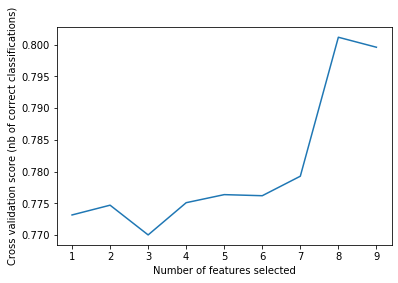

In [16]:
print("Optimal number of features : %d" % rfecv.n_features_)
print("Optimal number of features : %s" % str(rfecv.support_))

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()


In [ ]:
mask = ~pd.isna(comparisons[['accuracy', 'predicted']]).any(axis=1)
plt.figure()
vals_correct, bins, _ = plt.hist(comparisons['predicted'][mask & (comparisons['accuracy'] == 1)], alpha=0.5, label='good', bins=30)
vals_incorrect,_,_ = plt.hist(comparisons['predicted'][mask & (comparisons['accuracy'] == 0)], alpha=0.5, label='bad', bins=bins)
plt.xlabel('predicted probability that the user is good')
plt.ylabel('count')
plt.legend()

In [ ]:
def get_class_color(name):
    if users.loc[name]['class'] == 'undefined':
        return (0.5, 0.5, 0.5)
    elif users.loc[name]['class'] == 'bad':
        return (1, 0, 0)
    elif users.loc[name]['class'] == 'good':
        return (0, 1, 0)
    elif users.loc[name]['class'] == 'region':
        return (0, 0, 1)
    
    return (0.5, 0.5, 0.5)

# comparisons = comparisons.drop(columns=('color'))
comparisons = comparisons.join(comparisons.apply(lambda x: get_class_color(x.name), axis=1).rename('color'))

# #%%
# plt.figure()
# plt.ylabel('relative importance')
# plt.title('Feature Importances')
# plt.xticks(rotation=90)
# plt.bar(features, clf.feature_importances_)

In [ ]:
plt.figure(figsize=(5, 5))
# plt.xlim((20, 100))
# plt.ylim((20, 100))
# plt.axis('scaled')
plt.xlabel('Predicted accuracy')
plt.ylabel('Actual accuracy')
# plt.scatter(comparisons['predicted'], comparisons['accuracy'], c=comparisons['color'].values)
plt.scatter(comparisons['predicted'], comparisons['accuracy'], c=comparisons['split_num'])
# plt.scatter(comparisons['predicted'], comparisons['confidence'], c=comparisons['color'].values)

# z = np.polyfit(comparisons['predicted'], comparisons['accuracy'], 1)
# p = np.poly1d(z)
# plt.plot(comparisons['predicted'], p(comparisons['predicted']), 
#     label=f"y={z[0]:2f}x+({z[1]:2f}), {r2_score(comparisons['accuracy'], p(comparisons['predicted'])):2f}")
plt.legend()



In [ ]:
plt.figure(figsize=(5, 5))
plt.xlim((20, 100))
plt.ylim((20, 100))
plt.axis('scaled')
plt.xlabel('Predicted accuracy')
plt.ylabel('Actual accuracy')
for train_index, test_index in KFold(n_splits=5, shuffle=True, random_state=0).split(users.index):
    X_train, X_test = users.index[train_index], users.index[test_index]
    y_train, y_test = users['accuracy'][train_index], users['accuracy'][test_index]

    #%%
    from sklearn.ensemble import BaggingRegressor
    clf = BaggingRegressor(n_jobs=-1, random_state=0, n_estimators=100)

    #%%
    np.array([list(l) for l in comparisons.loc[X_train]['prob_hist'].values])

    #%%
    clf.fit([list(l) for l in comparisons.loc[X_train]['prob_hist'].values], comparisons.loc[X_train]['accuracy'])


    #%%
    prediction = clf.predict([list(l) for l in comparisons.loc[X_test]['prob_hist'].values])
    prediction = pd.Series(data=prediction, index=X_test)
    #%%
    plt.scatter(prediction, y_test)
    #%%



# Analysis of min labels vs. precision

In [20]:
%%time
warnings.filterwarnings('ignore')
def run_range(min_labels):
    try:
        print(min_labels)
        users_for_analysis = users.index[users['labels_validated'] > min_labels]
        users2 = users.loc[users_for_analysis]
        return get_p_r(users2, label_correctness)
    except Exception:
        return (-1, -1)
    
with mp.Pool(4) as p:
    results = p.map(run_range, np.arange(1,75))

6
16
11
1
17
2
12
7
18
8
3
13
19
9
14
4
20
15
10
5
21
26
31
22
36
27
32
23
37
28
33
38
24
29
34
39
25
30
35
40
41
46
51
56
42
57
47
52
43
58
48
53
44
59
49
54
45
60
55
50
61
66
71
62
67
72
63
68
73
64
69
74
65
70
CPU times: user 310 ms, sys: 109 ms, total: 420 ms
Wall time: 4min 26s


In [23]:
results = np.array(results)

In [48]:
results_with_min = np.concatenate((np.arange(2, 76).reshape(-1, 1), results), axis=1)
results_invalid = results_with_min[~(results == -1).any(axis=1)]
results_df = pd.DataFrame(data=results_invalid, columns=('min', 'precision', 'recall')).set_index('min')

In [65]:
results_df = results_df.iloc[results_df.index < 45]

Text(0, 0.5, 'recall')

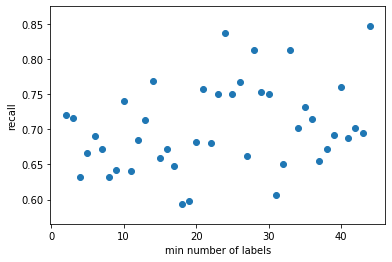

In [79]:
plt.figure()
# plt.scatter(results_df.index, results_df['precision'])
plt.scatter(results_df.index, results_df['recall'])
# plt.scatter(results_df.index, 2/(1/results_df['precision'] + 1/results_df['recall']))
plt.xlabel('min number of labels')
plt.ylabel('recall')

In [88]:
results[44]

array([0.87804878, 0.8372093 ])

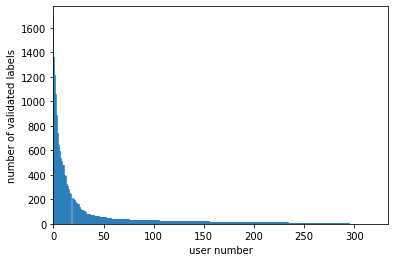

In [126]:
fig = plt.figure()
plt.vlines(np.arange(len(users['labels_validated'])), 0, np.sort(users['labels_validated'])[::-1], color='C0')
plt.axis((0, None, 0, None))
plt.xlabel('user number')
plt.ylabel('number of validated labels')
fig.savefig('a.svg')

In [106]:
 np.sort(users['labels_validated'])[::-1]

array([1690, 1365, 1217, 1063,  886,  737,  639,  592,  541,  510,  482,
        482,  399,  391,  321,  311,  284,  255,  242,  213,  203,  193,
        176,  172,  165,  164,  136,  117,  111,  110,  108,  101,   94,
         83,   79,   79,   76,   71,   70,   69,   68,   67,   67,   64,
         63,   62,   59,   57,   54,   54,   53,   53,   53,   47,   46,
         45,   44,   44,   43,   42,   42,   41,   41,   40,   40,   40,
         39,   39,   39,   39,   39,   38,   38,   38,   37,   36,   35,
         35,   34,   34,   33,   33,   32,   32,   32,   32,   32,   31,
         31,   31,   31,   30,   30,   30,   30,   30,   30,   29,   29,
         29,   28,   28,   28,   27,   27,   27,   26,   26,   26,   26,
         26,   26,   25,   25,   25,   25,   24,   24,   24,   23,   23,
         23,   23,   23,   23,   23,   22,   22,   22,   21,   21,   21,
         21,   21,   21,   21,   21,   21,   21,   20,   20,   20,   20,
         20,   20,   20,   20,   20,   20,   20,   